In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os.path import exists
import os

# Notes

I'm thinking that my outfiles and Kurtis' are different, in that mine have some summary data at the end. I will need to modify the way he read in files to stop at a specific phrase. 

### UPDATE

He used a bash script to trim the RIBO outputs. I'm using a modified version so the raw files are kept. That way we can see the proportion of time spent in each cell (helpful for diagnosing issues and making observations).


## Also
I'm adding colour customization to the plots. Because I want to.

In [323]:
#reads outfiles without me having to remember the parameters we want to use
def load(outfile):
    data = pd.read_csv('Data/'+outfile,header=26,delim_whitespace=True)
    return data

#this is Kurtis' fastSlow
#aka the effusion equation
#to be used with scipy.curve_fit; it will find the correct parameters
def eff(t,C,t1,t2):
    eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)
    return eff
#this is a different equation that I sometimes used to try to fit the effusion curves
#Never panned out, but the equation is solid (also used in RIBO prelim fits)
def slow_eff(t,C,t1,t2):
    eff = C*np.exp(-t/t1)/t1
    return eff
#this is Kurtis' plotHistogram
def plot_hist(data,                   #list or sim. (from outfile)
              label=None,             #for plot legend
              col='#000000',          #for plot line/scatter
              mark=True,              #include scatter
              norm=False,             #normalize by number of counts
              lin=10000,              #number of 'bins' for line (large for smooth curve)
              bbin=50,                #number of bins for histogram
              peak=False,             #include dotted vertical line at curve peak
              guess=(10,1e-3,1e-2),   #initial guess for the curve fittingn
              domain=(0,0.2),         #range of the times to use for binning
              slow=False              #use slow equation rather than fast (atypical)
             ):
    #create histogram (of effusion times)
    counts, bins = np.histogram(data, range=domain, bins=bbin, density=False) 
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    
    #fit the curve (outputs: nOpt[0:2] = C,t1,t2 ; nVar = covariance of nOpt)
    if slow == True:
        nOpt,nVar = curve_fit(slow_eff,bins_mean,counts,p0=guess)
    else:
        nOpt, nVar = curve_fit(eff, bins_mean, counts, p0=guess)
    
    print(f"Fit for {label} (Samples = {len(data.index)}) is,t_1 = {nOpt[1]:.2e} \
    +/- {np.sqrt(nVar[1][1]):.2e} AND t_2 = {nOpt[2]:.2e} +/- {np.sqrt(nVar[2][2]):.2e}")
    linspace = np.linspace(0, np.max(bins_mean),lin)
    if mark == True and norm == False: 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),color=col)
        plt.scatter(bins_mean, counts, marker="+", label=label,color=col)
    elif mark == True:  #mark = True; norm = True
        plt.scatter(bins_mean, counts/data.shape[0], marker="+", label=label,color=col) 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],color=col)
    elif norm == False: #mark = False; norm = False
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),label=label,color=col)
        #FIX**plt.errorbar(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),yerr=nVar)
    else: #mark = False; norm = True
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],label=label,color=col)
    #add in vertical line at peak 
    if peak == True:
        p1 = plt.axvline(x=linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))]
                         ,linestyle='--',color=col)
        print('Peak time (s) =',linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))])
        return p1

def plot_hist_onion(data,label=None,col='#000000',mark=True,norm=False,lin=10000,bbin=50,
              peak=False,guess=(10,1e-3,1e-2),domain=(0,0.2),slow=False,t0=0):
    #display hist as a series of points for clarity
    counts, bins = np.histogram(data+t0, range=domain, bins=bbin, density=False) 
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    
    #fit the curve (outputs: nOpt[0:2] = C,t1,t2 ; nVar = covariance of nOpt)
    if slow == True:
        nOpt,nVar = curve_fit(slow_eff,bins_mean,counts,p0=guess)
    else:
        nOpt, nVar = curve_fit(eff, bins_mean, counts, p0=guess)
    
    print(f"Fit for {label} (Samples = {len(data.index)}) is,t_1 = {nOpt[1]:.2e} \
    +/- {np.sqrt(nVar[1][1]):.2e} AND t_2 = {nOpt[2]:.2e} +/- {np.sqrt(nVar[2][2]):.2e}")
    linspace = np.linspace(0, np.max(bins_mean),lin)
    if mark == True and norm == False: 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),color=col)
        plt.scatter(bins_mean, counts, marker="+", label=label,color=col)
    elif mark == True:  #mark = True; norm = True
        plt.scatter(bins_mean, counts/data.shape[0], marker="+", label=label,color=col) 
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],color=col)
    elif norm == False: #mark = False; norm = False
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]),label=label,color=col)
    else: #mark = False; norm = True
        plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2])/data.shape[0],label=label,color=col)
    if peak == True:
        p1 = plt.axvline(x=linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))]
                         ,linestyle='--',color=col)
        print('Peak time (s) =',linspace[np.argmax(eff(linspace, nOpt[0], nOpt[1], nOpt[2]))])
        return p1

#this is Kurtis' plotCollisionHistogram
def plot_coll_hist(data, label=None,col='#000000'):
    #display hist as a series of points for clarity
    #these are different versions of *********count,bins********
    counts, bins = np.histogram(data, range=(0,max(data)), bins=20)
    #bins=np.logspace(0, 8, 25)) #, range=(0,0.05), bins=50,density=True)
    #counts, bins = np.histogram(data, bins=1000)#, range=(0,0.05), bins=50,density=True)
    
    #normalize according to number of counts 
    counts = counts/len(data.index)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    
    #fit the curve
    #nOpt, nVar = curve_fit(eff, bins_mean, counts, p0=(10, 1e-03, 1e-02 ))
    #print(f"Fit for {label} (Samples = {len(data.index)}) is, t_1 = {nOpt[1]:.2e}
    #+/- {np.sqrt(nVar[1][1]):.2e} AND t_2 = {nOpt[2]:.2e} +/- {np.sqrt(nVar[2][2]):.2e}")
    plt.plot(bins_mean, counts, marker=".", label=label,color=col) 
    #linspace = np.linspace(0, np.max(bins_mean),10000)
    #plt.plot(linspace, eff(linspace, nOpt[0], nOpt[1], nOpt[2]))

#Kurtis' plotDecay
def plot_decay(data,            #list or sim. (from outfile)
               label,           #for plot legend
               t12,             #halflife
               col,             #colour for with decay
               col2='#000000',  #colour for without decay (ctrl)
               ctrl=False,      #include a 'control' without decay
               bbin=50          #bins in histogram
              ):
    #display the histogram, and convolute with decay
    if t12 > 0.1: rr = (0,0.05)
    else: rr = (0,t12*5)
    counts, bins = np.histogram(data, range=rr, bins=bbin, density=False)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    decay = [np.exp(-0.693*bins_mean[i]/t12) for i in range(len(counts))] 
    decaycounts = counts*decay
    plt.scatter(bins_mean, decaycounts, marker="+", label=label,color=col) 
    if ctrl == True:
        plt.scatter(bins_mean, counts, s=12,label="No decay",color=col2)
        
#my plot_decay but with the pulse
def plot_decay_onion(data,             #list or sim. (from outfile)
                     label,            #for plot legend
                     t12,              #halflife
                     t0,               #list of when each primary starts (aka shift or time at beginning)
                     col,              #colour for scatter
                     ts=0,             #sticking time (int or float)
                     bbin=50,          #number of bins in histogram
                     rr=None           #range of data for histogram
                    ):
    #display the histogram, and convolute with decay
    decay = np.exp(-0.693* (data+ts) /t12)
    print(decay[0])
    onion = (data+ts)*decay+t0
    if rr == None:
        if t12 > 0.1: rr = (0,t12*2)
        else: rr = (0,t12*10)
    counts, bins = np.histogram(onion, range=rr, bins=bbin,density=False)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    plt.scatter(bins_mean, counts, marker="+", label=label,color=col,zorder=2) 

#my plot_decay_onion but with the activity added to it
#attempting to reproduce the plot from the powerpoint (blue/green)
def plot_ppt2(data,           #list or sim. (from outfile)
              label,          #for plot legend
              t12,            #halflife
              t0,             #list of when each primary starts (aka shift or time at beginning)
              ts=0,           #sticking time (int or float)
              bbin=50,        #number of bins in histogram
              rr=None,        #range of hist data
              which='blue'    #green or blue (which line of the ppt plot to emulate)
             ):
    #setting up shifting (teff+ts+shift array)
    onion = data+ts+t0
    #hist of times including shifting
    counts, bins = np.histogram(onion, range=rr, bins=bbin, density=False)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    #defining decay based on number of counts in previous bin (not based on t=0 since t0 varies by primary)
    decay = np.exp(-0.693*(bins_mean[1]-bins_mean[0])/t12)
    print(decay)
    print(counts[1])
    new_counts,blue_counts,green_counts = np.empty(bbin),np.empty(bbin),np.empty(bbin)
    new_counts[0] = counts[0]
    blue_counts[0] = counts[0]
    green_counts[0] = 0.0
    for ii in range(1,bbin):
        #ion counts = previous bin's counts*decay between bins + new primaries effused here
        #maybe that's green? (i.e., activity)
        new_counts[ii] = new_counts[ii-1]*decay + counts[ii]
    #green counts = activity (/ms) of the ion counts of this bin #decays from this bin's ion counts
        green_counts[ii] = new_counts[ii-1]*(1-decay)
        #(1/1000)*(0.693/(t12))*new_counts#ion_counts[ii]*(1-decay)#blue_counts[ii-1]*(1-decay)
    #blue counts = activity + ion counts
    blue_counts = green_counts+new_counts#(blue_counts[ii-1]*decay)+counts[ii]
    print(blue_counts[100],green_counts[100],new_counts[100])
    if which == 'green':
        plt.scatter(bins_mean,green_counts,marker="+", label=label,color='#849007',zorder=2)
    else: #blue
        plt.scatter(bins_mean,blue_counts,marker="+", label=label,color='#203754',zorder=2)

#Kurtis' calcEffusionEfficiency
def calc_eff_eff(data, t12):
    counts, bins = np.histogram(data, range=(0,10), bins=100, density=True)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    Integrandpt1 = counts*(bins[1]-bins[0])
    decay = [np.exp(-0.693*bins_mean[i]/t12) for i in range(len(counts))] 
    eff = np.sum(decay*Integrandpt1)
    print(f"Effusion Efficiency: {eff:.2e}")

#Kurtis' plotNumInt (cumulative)
def plot_cumulative(data, label=None,col='#000000',bbin=50):
    counts, bins = np.histogram(data, bins=bbin, density=True) 
    cumcounts = np.cumsum(counts*(bins[1]-bins[0]))
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))] 
    plt.scatter(bins_mean, cumcounts,label=label,color=col,s=10)

#plot_decay with culumative
def plot_combo(data,           #list or sim. (from outfile)
               t12=4.35e-3,    #half-life
               label=None,     #for plot legend (for the scatter that includes decay)
               label2=None,    #for plot legend (for the scatter that doesn't include decay: ctrl)
               col='#000000',  #for scatter that includes decay
               col2='#666666', #for the scatter that doesn't include decay: ctrl
               bbin=50,        #bins in hist
               ctrl=False,     #include 'control' that doesn't include decay
               line=True,      #include dotted vertical lines at specified half-lives
               domain=None     #range for data in hist
              ):
    if domain == None:
        counts, bins = np.histogram(data,bins=bbin,range=(0,t12*20), density=True)
    else:
        counts, bins = np.histogram(data,bins=bbin,range=domain, density=True)
    
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(counts))]
    decay = [np.exp(-0.693*bins_mean[i]/t12) for i in range(len(counts))]
    decaycounts = counts*decay
    decaycumcounts = np.cumsum(decaycounts*(bins[1]-bins[0]))
    cumcounts = np.cumsum(counts*(bins[1]-bins[0]))
    plt.scatter(bins_mean, decaycumcounts, marker=".",s=12,label=label,color=col,zorder=2) 
    if ctrl == True:
        plt.scatter(bins_mean, cumcounts, marker=".",s=12, label=label2,color=col2,zorder=2)
    
    print(f"Maximum Release Fraction = {decaycumcounts[-1]:.3%}")
    target = t12
    diffs = abs(np.array(bins_mean)-t12)
    idx = np.argmin(diffs)
    print(f"Release Fraction at 1 half-life = {decaycumcounts[idx]:.3%}")
    print(f"Release Fraction at 2 half-lives = {decaycumcounts[idx*2]:.3%}")
    if domain == None:
        print(f"Release Fraction at 5 half-lives = {decaycumcounts[idx*5]:.3%}")
        print(f"Release Fraction at 10 half-lives = {decaycumcounts[idx*10]:.3%}")
    
    if line == True:
        p_list = []
        for ii in [1,2,3,4,5,10]:
            p_list.append(plt.axvline(x=t12*ii,linestyle='--',color=col2,zorder=1))
        
        return p_list
    

In [310]:
def gap(number=470,length=3.4,thickness=25,sep=0,squish=1):
    gap = (length*squish-(number*thickness*1e-4)-sep)/(number+1)
    return gap

## Arc

In [110]:
ion = [4.1253,5.956]
nuc = ['Li8','Be14']
data = {}
ion_clean = [] #for labels
ion_name = []  #for file naming
mini = []
primaries = []
for nn in nuc:
    dat = {}
    for idx,ii in enumerate(ion):
        st = str(round(ii,4))
        st = st.replace('.','_')
        if nn == 'Li8': 
            ion_name.append(st)
            ion_clean.append((f"{ii*10:.2e} mm"))
        mini = []
        for jj in range(1,23):
            d = load('Arc/CLEAN/'+nn+'-'+st+'-'+str(jj)+'.out')
            d = d.dropna(subset=['tT'])
            mini.append(d)
        dd = pd.concat(mini,ignore_index=True)
        print(dd.shape[0])
        primaries.append(dd.shape[0])
        dat[ii] = dd
    data[nn] = dat
print(primaries,min(primaries))
for nn in nuc:
    for ii in ion:
        data[nn][ii] = data[nn][ii][:min(primaries)] 
        #cuts down to min size of outfile so number of primaries is consistent
        print(data[nn][ii].shape[0])

9208
8182
8881
7969
[9208, 8182, 8881, 7969] 7969
7969
7969
7969
7969


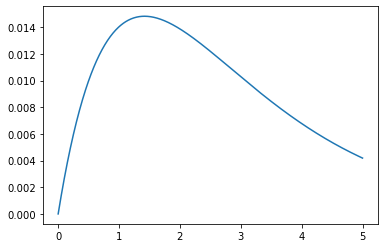

In [125]:
t = np.linspace(0,5,1000)
t0 = np.linspace(0,0.1,1000)
g = 1*(1-np.exp(-t0/0.839))*(np.exp(-0.693*t)/0.839)
#plt.ylim(0,0.4)
plt.plot(t,g)
plt.show()

[Errno 17] File exists: './Plots/Arc/'
Don't worry; things are still running smoothly :)
Maximum Release Fraction = 98.435%
Release Fraction at 1 half-life = 98.435%
Release Fraction at 2 half-lives = 98.435%
Release Fraction at 5 half-lives = 98.435%
Release Fraction at 10 half-lives = 98.435%
Maximum Release Fraction = 97.648%
Release Fraction at 1 half-life = 97.648%
Release Fraction at 2 half-lives = 97.648%
Release Fraction at 5 half-lives = 97.648%
Release Fraction at 10 half-lives = 97.648%


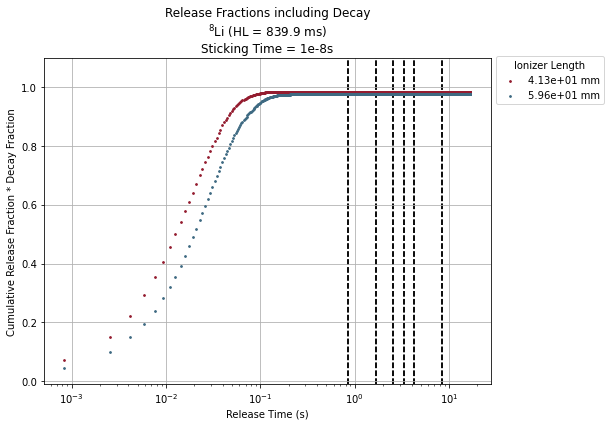

/var/folders/9n/nhtmq0l50ys2lvrp45z8vqbc0000gn/T/ipykernel_53244/1886460068.py:9: RuntimeWarning: overflow encountered in exp
  eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)
/var/folders/9n/nhtmq0l50ys2lvrp45z8vqbc0000gn/T/ipykernel_53244/1886460068.py:9: RuntimeWarning: overflow encountered in multiply
  eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)


Fit for 4.13e+01 mm (Samples = 7969) is,t_1 = 5.48e-04     +/- 2.20e-05 AND t_2 = 1.87e-02 +/- 1.82e-04
Fit for 5.96e+01 mm (Samples = 7969) is,t_1 = 5.73e-04     +/- 3.35e-05 AND t_2 = 2.91e-02 +/- 3.59e-04


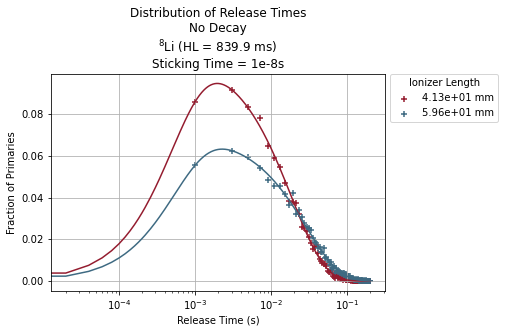

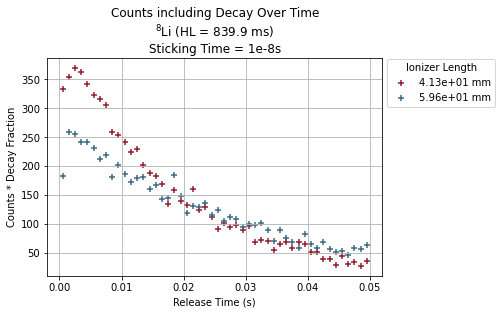

Maximum Release Fraction = 19.913%
Release Fraction at 1 half-life = 10.883%
Release Fraction at 2 half-lives = 16.003%
Release Fraction at 5 half-lives = 19.634%
Release Fraction at 10 half-lives = 19.909%
Maximum Release Fraction = 15.659%
Release Fraction at 1 half-life = 8.469%
Release Fraction at 2 half-lives = 12.391%
Release Fraction at 5 half-lives = 15.372%
Release Fraction at 10 half-lives = 15.654%


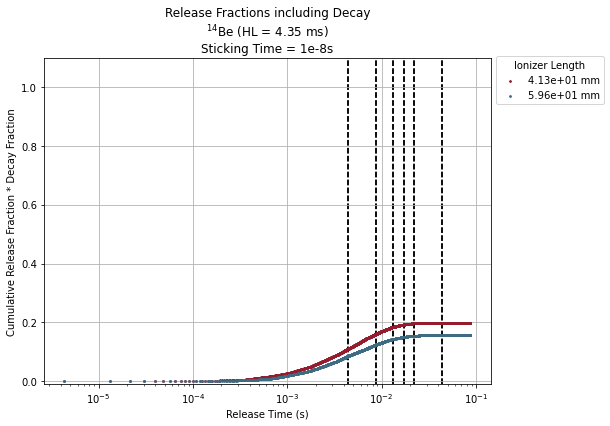

Fit for 4.13e+01 mm (Samples = 7969) is,t_1 = 6.05e-04     +/- 3.49e-05 AND t_2 = 2.43e-02 +/- 3.33e-04
Fit for 5.96e+01 mm (Samples = 7969) is,t_1 = 5.79e-04     +/- 4.22e-05 AND t_2 = 3.54e-02 +/- 5.05e-04


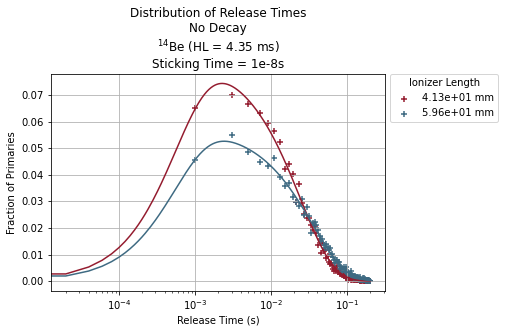

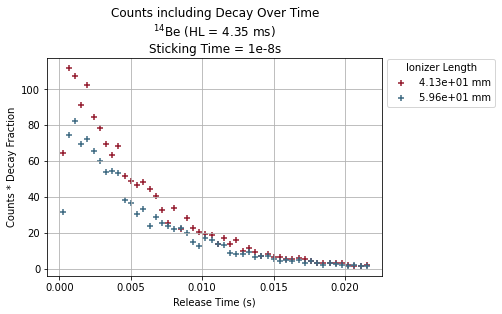

In [112]:
DIR = 'Plots/Arc/'
try:
    os.mkdir('./'+DIR)
except OSError as error:
    print(error)  
    print('Don\'t worry; things are still running smoothly :)')
nuclides = [r'$^8$Li',r'$^{14}$Be']
HL = [839.9e-3,4.35e-3]
HLC = ['839.9 ms','4.35 ms']
col = ["#941c2f",
       "#3e6a82","#656e85"]
guess = []
t1 = [4e-3,1e-4,1e-3,1e-3]
t2 = [1e-2,1e-3,1e-2,3e-2]
domain = []
dom = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-2]
for tt1,tt2,dd in zip(t1,t2,dom):
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd*1.5))
# domain[0] = (1e-8,1e-4)
# domain[-1] = (1e-5,5e-3)
    
for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
    for idx2,ii in enumerate(data[nn].keys()):
        leg.append(plot_combo(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True))

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Cumulative Release Fraction * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    plt.ylim(-0.01,1.1)
    plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        bbin = 100
        plot_hist(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,
                  label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
                  lin=10000,bbin=bbin,peak=False,guess=guess[idx2])#,domain=domain[idx2])

    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Fraction of Primaries')
    #plt.xlim(1e-7,1e-2)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Release Times\nNo Decay\n'
              +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        plot_decay(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2=col[idx2],ctrl=False)

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    #plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Counts * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    #plt.ylim(-0.01,1.1)
    plt.title('Counts including Decay Over Time\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'decay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    

## Run 9

In [ ]:
ion = [3.2099,4.1253,5.956]
nuc = ['Li8','Be14']
data = {}
ion_clean = [] #for labels
ion_name = []  #for file naming
mini = []
primaries = []
for nn in nuc:
    dat = {}
    for idx,ii in enumerate(ion):
        st = str(round(ii,4))
        st = st.replace('.','_')
        if nn == 'Li8': 
            ion_name.append(st)
            ion_clean.append((f"{ii*10:.2e} mm"))
        mini = []
        for jj in range(1,23):
            d = load('1250K/CLEAN/'+nn+'-'+st+'-'+str(jj)+'.out')
            d = d.dropna(subset=['tT'])
            mini.append(d)
        dd = pd.concat(mini,ignore_index=True)
        print(dd.shape[0])
        primaries.append(dd.shape[0])
        dat[ii] = dd
    data[nn] = dat
print(primaries,min(primaries))
for nn in nuc:
    for ii in ion:
        data[nn][ii] = data[nn][ii][:min(primaries)] 
        #cuts down to min size of outfile so number of primaries is consistent
        print(data[nn][ii].shape[0])

In [ ]:
DIR = 'Plots/1250K/'
try:
    os.mkdir('./'+DIR)
except OSError as error:
    print(error)  
    print('Don\'t worry; things are still running smoothly :)')
nuclides = [r'$^8$Li',r'$^{14}$Be']
HL = [839.9e-3,4.35e-3]
HLC = ['839.9 ms','4.35 ms']
col = ["#BB735F","#941c2f","#e76f51","#D5A220","#8ab17d",
       "#3e6a82"]
guess = []
t1 = [1e-9,1e-5,1e-5,1e-5]
t2 = [1e-5,1e-5,1e-5,3e-5]
domain = []
dom = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-2]
for tt1,tt2,dd in zip(t1,t2,dom):
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd*1.5))
domain[0] = (1e-8,1e-3)
# domain[-1] = (1e-5,5e-3)
    
for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
#     for idx2,ii in enumerate(data[nn].keys()):
#         leg.append(plot_combo(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
#                               label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
#                               col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True))

# #     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
# #     plt.gca().add_artist(leg1)
#     plt.xscale('log')
#     plt.xlabel('Release Time (s)')
#     plt.ylabel('Cumulative Release Fraction * Decay Fraction')
#     #plt.xlim(1e-8,0.2)
#     plt.ylim(-0.01,1.1)
#     plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
#     plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
#     plt.grid(True,zorder=-1.0)
#     plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
#     plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        bbin = 50
        plot_hist(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,
                  label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
                  slow=True,
                  lin=1000,bbin=bbin,peak=False,guess=guess[idx2],domain=domain[idx2])

    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Fraction of Primaries')
    #plt.xlim(1e-7,1e-2)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Release Times\nNo Decay\n'
              +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    

# Standard

In [322]:
data['Li8'][4.1253]['tT']

0       0.017090
1       0.001322
2       0.012021
3       0.010456
4       0.004123
          ...   
7096    0.019203
7097    0.003974
7098    0.024891
7099    0.050099
7100    0.007599
Name: tT, Length: 7101, dtype: float64

In [319]:
ion = [4.1253,5.956]
nuc = ['Li8','Be14']
data = {}
ion_clean = [] #for labels
ion_name = []  #for file naming
mini = []
primaries = []
for nn in nuc:
    dat = {}
    for idx,ii in enumerate(ion):
        st = str(round(ii,4))
        st = st.replace('.','_')
        if nn == 'Li8': 
            ion_name.append(st)
            ion_clean.append((f"{ii*10:.2e} mm"))
        mini = []
        for jj in range(1,23):
            d = load('Standard/CLEAN/'+nn+'0-'+st+'-'+str(jj)+'.out')
            d = d.dropna(subset=['tT'])
            mini.append(d)
        dd = pd.concat(mini,ignore_index=True)
        print(dd.shape[0])
        primaries.append(dd.shape[0])
        dat[ii] = dd
    data[nn] = dat
print(primaries,min(primaries))
for nn in nuc:
    for ii in ion:
        data[nn][ii] = data[nn][ii][:min(primaries)] 
        #cuts down to min size of outfile so number of primaries is consistent
        print(data[nn][ii].shape[0])

9317
7101
9070
8004
[9317, 7101, 9070, 8004] 7101
7101
7101
7101
7101


[Errno 17] File exists: './Plots/Standard/'
Don't worry; things are still running smoothly :)
Maximum Release Fraction = 98.461%
Release Fraction at 1 half-life = 98.461%
Release Fraction at 2 half-lives = 98.461%
Release Fraction at 5 half-lives = 98.461%
Release Fraction at 10 half-lives = 98.461%
Maximum Release Fraction = 97.716%
Release Fraction at 1 half-life = 97.716%
Release Fraction at 2 half-lives = 97.716%
Release Fraction at 5 half-lives = 97.716%
Release Fraction at 10 half-lives = 97.716%


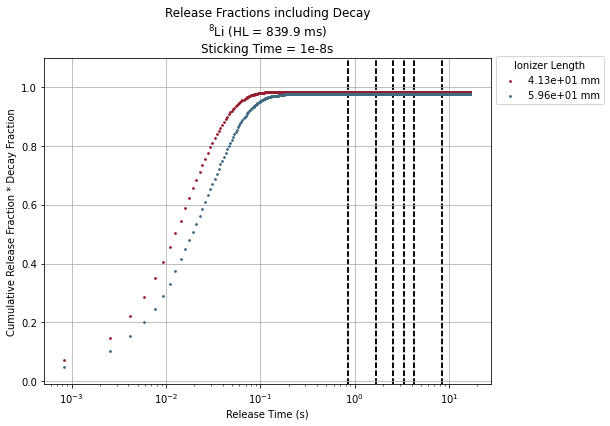

Fit for 4.13e+01 mm (Samples = 7101) is,t_1 = 5.22e-04     +/- 1.65e-05 AND t_2 = 1.87e-02 +/- 1.38e-04
Fit for 5.96e+01 mm (Samples = 7101) is,t_1 = 5.29e-04     +/- 3.25e-05 AND t_2 = 2.81e-02 +/- 3.45e-04


/var/folders/9n/nhtmq0l50ys2lvrp45z8vqbc0000gn/T/ipykernel_53244/3267497573.py:9: RuntimeWarning: overflow encountered in exp
  eff = C*(1-np.exp(-t/t1))*np.exp(-t/t2)


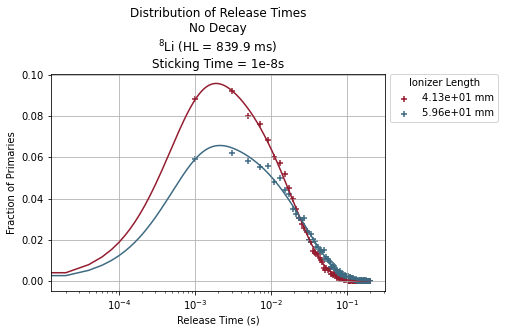

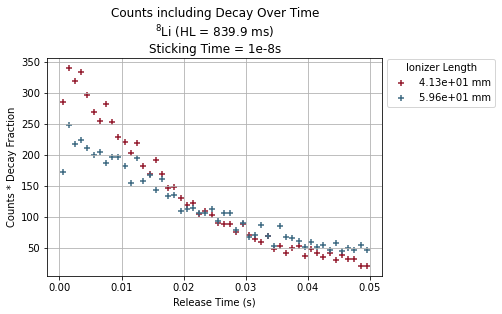

Maximum Release Fraction = 20.321%
Release Fraction at 1 half-life = 11.116%
Release Fraction at 2 half-lives = 16.525%
Release Fraction at 5 half-lives = 20.044%
Release Fraction at 10 half-lives = 20.318%
Maximum Release Fraction = 14.752%
Release Fraction at 1 half-life = 7.591%
Release Fraction at 2 half-lives = 11.518%
Release Fraction at 5 half-lives = 14.471%
Release Fraction at 10 half-lives = 14.748%


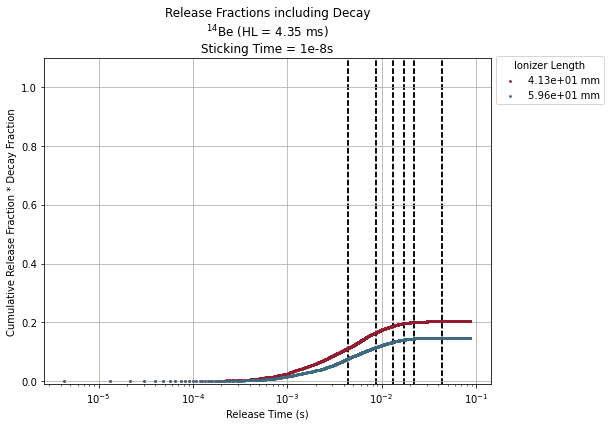

Fit for 4.13e+01 mm (Samples = 7101) is,t_1 = 5.67e-04     +/- 2.37e-05 AND t_2 = 2.38e-02 +/- 2.26e-04
Fit for 5.96e+01 mm (Samples = 7101) is,t_1 = 7.46e-04     +/- 5.55e-05 AND t_2 = 3.67e-02 +/- 6.13e-04


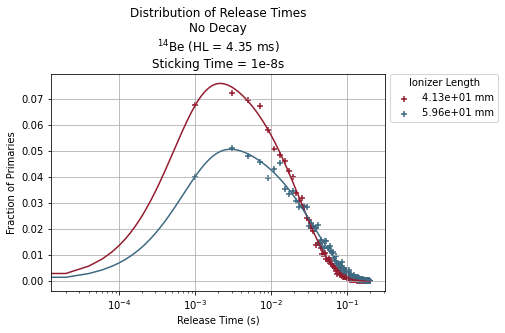

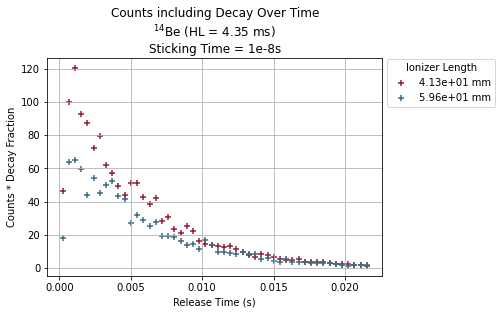

In [324]:
DIR = 'Plots/Standard/'
try:
    os.mkdir('./'+DIR)
except OSError as error:
    print(error)  
    print('Don\'t worry; things are still running smoothly :)')
nuclides = [r'$^8$Li',r'$^{14}$Be']
HL = [839.9e-3,4.35e-3]
HLC = ['839.9 ms','4.35 ms']
col = ["#941c2f",
       "#3e6a82","#656e85"]
guess = []
t1 = [4e-3,1e-3,1e-3,1e-3]
t2 = [1e-2,1e-3,1e-2,3e-2]
domain = []
dom = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-2]
for tt1,tt2,dd in zip(t1,t2,dom):
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd*1.5))
# domain[0] = (1e-8,1e-4)
# domain[-1] = (1e-5,5e-3)
    
for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
    for idx2,ii in enumerate(data[nn].keys()):
        leg.append(plot_combo(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True))

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Cumulative Release Fraction * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    plt.ylim(-0.01,1.1)
    plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        bbin = 100
        plot_hist(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,
                  label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
                  lin=10000,bbin=bbin,peak=False,guess=guess[idx2])#,domain=domain[idx2])

    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Fraction of Primaries')
    #plt.xlim(1e-7,1e-2)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Release Times\nNo Decay\n'
              +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        plot_decay(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2=col[idx2],ctrl=False)

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    #plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Counts * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    #plt.ylim(-0.01,1.1)
    plt.title('Counts including Decay Over Time\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'decay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    

# Onion Layers

In [ ]:
onion = {}
for nn in data.keys():
    onion[nn] = {}
    for ii in data[nn].keys():
        onion[nn][ii] = data[nn][ii].copy()
shift = np.linspace(0,100e-3,onion['Li8'][5.956].shape[0]) 
print(onion['Li8'][5.956]['tT'][7100])
for nn in onion.keys():
    for ii in onion[nn].keys():
        onion[nn][ii].loc[:,'tT'] += shift
print(onion['Li8'][5.956]['tT'][7100])
print(onion['Li8'][5.956].shape[0])
onion['Li8'][4.1253]

[Errno 17] File exists: './Plots/Standard-Onion/'
Don't worry; things are still running smoothly :)
0.9991752420739619
6
5594.021683592444 4.548557845814793 5589.473125746629
0.9991752420739619
6
5594.021683592444 4.548557845814793 5589.473125746629


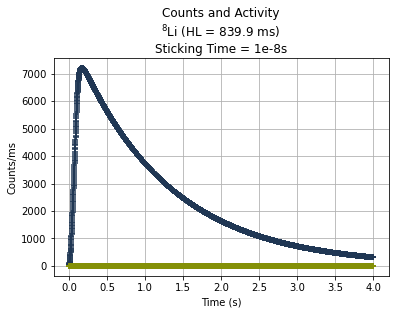

0.8527316770346346
1
553.1450440552549 71.29922871001034 481.84581534524455
0.8527316770346346
1
553.1450440552549 71.29922871001034 481.84581534524455


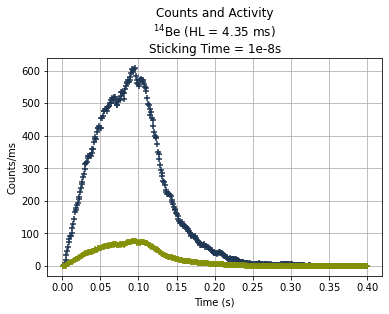

In [318]:
DIR = 'Plots/Standard-Onion/'
try:
    os.mkdir('./'+DIR)
except OSError as error:
    print(error)  
    print('Don\'t worry; things are still running smoothly :)')
nuclides = [r'$^8$Li',r'$^{14}$Be']
HL = [839.9e-3,4.35e-3]
HLC = ['839.9 ms','4.35 ms']
col = ["#941c2f","#3e6a82","#656e85"]
ts = 1e-8
shift = np.linspace(0,100e-3,data['Li8'][5.956].shape[0]) 
guess = []
t1 = [4e-1,1e-3,1e-3,1e-3]
t2 = [1e-2,1e-3,1e-2,3e-2]
domain = []
dom = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-2]
for tt1,tt2,dd in zip(t1,t2,dom):
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd*1.5))
# domain[0] = (1e-8,1e-4)
# domain[-1] = (1e-5,5e-3)
lines=['blue','green']
    
for idx,nn in enumerate(data.keys()):
#     leg = []
#     plt.figure(figsize=(8,6))
#     for idx2,ii in enumerate(onion[nn].keys()):
#         leg.append(plot_combo(onion[nn][ii]['tT']+onion[nn][ii]['COL']*ts,t12=HL[idx],
#                               label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
#                               col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True))

# #     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
# #     plt.gca().add_artist(leg1)
#     plt.xscale('log')
#     plt.xlabel('Release Time (s)')
#     plt.ylabel('Cumulative Release Fraction * Decay Fraction')
#     #plt.xlim(1e-8,0.2)
#     plt.ylim(-0.01,1.1)
#     plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
#     plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
#     plt.grid(True,zorder=-1.0)
#     plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
#     plt.show()
    
#     for idx2,ii in enumerate(onion[nn].keys()):
#         bbin = 100
#         plot_hist(onion[nn][ii]['tT']+data[nn][ii]['COL']*ts,
#                   label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
#                   lin=10000,bbin=bbin,peak=False,guess=guess[idx2])#,domain=domain[idx2])

#     plt.xscale('log')
#     plt.xlabel('Release Time (s)')
#     plt.ylabel('Fraction of Primaries')
#     #plt.xlim(1e-7,1e-2)
#     #plt.ylim(-0.01,10000)
#     plt.title('Distribution of Release Times\nNo Decay\n'
#               +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
#     plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
#     plt.grid(True,zorder=-1.0)
#     plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
#     plt.show()
    
    #rr = [None,(0,0.2)]
    rr = [(0,4),(0,0.4)]
    for idx2,ii in enumerate(lines):
        bbin = int(rr[idx][1]*1000)
        plot_ppt2(data[nn][5.956]['tT'],ts=data[nn][5.956]['COL']*ts,t12=HL[idx],t0=shift,
                         label=ii,#label2=nuclides[idx]+', No decay',
                         bbin=bbin,line=False,rr=rr[idx],which=ii)

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    #plt.xscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Counts/ms')
    #plt.xlim(0,0.2)
    #plt.ylim(-0.01,1.1)
    plt.title('Counts and Activity\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    #plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'decay-'+nn+'-ppt.png',bbox_inches='tight',dpi=400)
    plt.show()

#     rr = [None,(0,0.2)]
#     for idx2,ii in enumerate(data[nn].keys()):
#         plot_hist_onion(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t0=shift,
#                          label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
#                          bbin=100,col=col[idx2],domain=rr[idx])

# #     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
# #     plt.gca().add_artist(leg1)
#     #plt.xscale('log')
#     plt.xlabel('Release Time (s)')
#     plt.ylabel('Counts * Decay Fraction')
#     #plt.xlim(1e-8,0.2)
#     #plt.ylim(-0.01,1.1)
#     plt.title('Counts including Decay Over Time\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
#     plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
#     plt.grid(True,zorder=-1.0)
#     plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
#     plt.show()
    
    ################FIX GUESS/DOMAIN
    

## Ionizer Only

In [ ]:
ion = np.linspace(1.3792,5.956*2-1.3792,11)
nuc = ['Li8','Be14']
data = {}
ion_clean = []
ion_name = []
mini = []
for nn in nuc:
    dat = {}
    for idx,ii in enumerate(ion[:-5]):
        st = str(round(ii,4))
        st = st.replace('.','_')
        if nn == 'Li8': 
            ion_name.append(st)
            ion_clean.append((f"{ii*10:.2e} mm"))
        mini = []
        for jj in range(1,23):
            d = load('ionizer/CLEAN/'+nn+'-'+st+'-'+str(jj)+'.out')
            d = d.dropna(subset=['tT'])
            mini.append(d)
        dd = pd.concat(mini,ignore_index=True)
        #print(dd.shape[0])
        dat[st] = dd[:10000]
        #print(dat[st].shape[0])
    data[nn] = dat


In [ ]:
ts = 1e-8
for ii in ion_name:
    print('Ionizer Length: ',ii)
    teff = sum(data['Li8'][ii]['teff'])/data['Li8'][ii]['teff'].shape[0]
    print(f"Teff: {teff:.2e}")
    coll = sum(data['Li8'][ii]['COL'])/data['Li8'][ii]['COL'].shape[0]
    print(f'Collisions: {coll:.3e}')
    tfts = sum(data['Li8'][ii]['teff']+ts*data['Li8'][ii]['COL'])/data['Li8'][ii]['teff'].shape[0]
    print(f'Teff+Ts: {tfts:.2e}')
    print()

In [ ]:
DIR = 'Plots/Ionizer-Alone/'
nuclides = [r'$^8$Li',r'$^{14}$Be']
HL = [839.9e-3,4.35e-3]
HLC = ['839.9 ms','4.35 ms']
col = ["#656e85","#941c2f","#e76f51","#D5A220","#8ab17d",
       "#3e6a82"]
guess = []
t1 = [4e-6,1e-6,1e-5,1e-8,1e-3,1e-3]
t2 = [1e-7,1e-7,1e-4,1e-5,1e-5,1e-4]
domain = []
dom = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-2]
for tt1,tt2,dd in zip(t1,t2,dom):
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd*1.5))
domain[0] = (1e-8,1e-4)
domain[-1] = (1e-5,5e-3)
    
for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
    for idx2,ii in enumerate(data[nn].keys()):
        if idx == 0: bbin = 1000000
        else: bbin = 10000
        leg.append(plot_combo(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2='#000000',bbin=bbin,ctrl=False,line=True))

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Cumulative Release Fraction * Decay Fraction')
    #plt.xlim(1e-8,0.2)
    plt.ylim(-0.01,1.1)
    plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    
    for idx2,ii in enumerate(data[nn].keys()):
        bbin = 100
        plot_hist(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,
                  label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
                  lin=10000,bbin=bbin,peak=False,guess=guess[idx2],domain=domain[idx2])

    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Fraction')
    plt.xlim(1e-7,1e-2)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Release Times\nNo Decay\n'
              +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    

In [ ]:
for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
    for idx2,ii in enumerate(data[nn].keys()):
        plot_coll_hist(data[nn][ii]['COL'],
                  label=ion_clean[idx2],col=col[idx2])

    #plt.xscale('log')
    plt.xlabel('Number of Collisions')
    plt.ylabel('Fraction of Primaries')
    #plt.xlim(0,1e5)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Collisions\n'
              +nuclides[idx])
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'coll-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()

In [ ]:
data['Li8']['2_2946']['teff'][0]

# ROTATION

In [ ]:
rot = [0]#,30,45]
nuc = ['Li8','Be14']
ion = [1.3792,5.956]
ion_name = ["1_3792","5_956"]
ion_clean = [(f"{ii*10:.2e} mm") for ii in ion]
data = {}
mini = []
for nn in nuc:
    print(nn)
    dat = {}
    for idx,rr in enumerate(rot):
        print(rr)
        da = {}
        for idx2,ii in enumerate(ion_name):
            print(ii)
            mini = []
            for jj in range(1,23):
                d = load('D-ion-rot/CLEAN/'+nn+str(rr)+'-'+str(ii)+'-'+str(jj)+'.out')
                #d = d.dropna(subset=['tT'])
                #d = d.dropna(subset=['COL'])
                mini.append(d)
            dd = pd.concat(mini,ignore_index=True)
            print(dd.shape[0])
            da[ii] = dd[:9300]
            print(da[ii].shape[0])
        dat[rr] = da
    data[nn] = dat
    
data['Li8'][0]['1_3792']

In [ ]:
DIR = 'Plots/Rot/'
nuclides = [r'$^8$Li',r'$^{14}$Be']
HL = [839.9e-3,4.35e-3]
HLC = ['839.9 ms','4.35 ms']
col = ["#941c2f","#656e85"]
guess = []
t1 = [1e-3,1e-2,1e-3,1e-2]
t2 = [1e-3,1e-2,1e-2,1e-2]
domain = []
dom = [0,0.2,0,0]
for tt1,tt2,dd in zip(t1,t2,dom):
    guess.append((10,tt1,tt2))
    domain.append((dd/100,dd))

for idx,nn in enumerate(data.keys()):
#     leg = []
#     print(data[nn].keys())
#     plt.figure(figsize=(8,6))
#     for idx2,ii in enumerate(data[nn][0].keys()):
#         leg.append(plot_combo(data[nn][0][ii]['tT']+data[nn][0][ii]['COL']*ts,t12=HL[idx],
#                               label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
#                               col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True))

# #     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
# #     plt.gca().add_artist(leg1)
#     plt.xscale('log')
#     plt.xlabel('Release Time (s)')
#     plt.ylabel('Cumulative Release Fraction * Decay Fraction')
#     #plt.xlim(1e-8,0.2)
#     plt.ylim(-0.01,1.1)
#     plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
#     plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
#     plt.grid(True,zorder=-1.0)
#     plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
#     plt.show()
    
    for idx2,ii in enumerate(data[nn][0].keys()):
        bbin = 100
        plot_hist(data[nn][0][ii]['tT']+data[nn][0][ii]['COL']*ts,
                  label=ion_clean[idx2],col=col[idx2],mark=True,norm=True,
                  lin=10000,bbin=bbin,peak=True,
                 guess=guess[2*idx+idx2],domain=(1e-4,0.2))

    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Fraction')
    #plt.xlim(1e-7,1e-2)
    #plt.ylim(-0.01,10000)
    plt.title('Distribution of Release Times\nNo Decay\n'
              +nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-ts-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()
    

## Collisions in the Large Batch of Basic 470 D-foils

In [ ]:
# data   = []
# gaps   = []
# for ii in range(1,111):
#     d = load('Li8-D-470/Li8-D-470-'+str(ii)+'.out')
#     data.append(d)
# data = pd.concat(data)

In [ ]:
# print(sum(data['COL'])/data.shape[0])

## Ionization in the Basic Geometry

In [ ]:
ion = np.linspace(1.3792,5.956*2-1.3792,11)
data = []
ion_clean = []
for idx,ii in enumerate(ion):
    st = str(round(ii,4))
    st = st.replace('.','_')
    print(st)
    mini = []
    for jj in range(1,9):
        d = load('D-ion/D-I-'+st+'-'+str(jj)+'.out')
        d = d.dropna(subset=['tT'])
        mini.append(d)
    dd = pd.concat(mini,ignore_index=True)
    data.append(dd)
    print(dd.shape[0])
    ion_clean.append((f"{ii*10:.2e} mm"))
sizes = [data[idx].shape[0] for idx in range(0,len(data))]
tiny = min(sizes)
print()
for idx in range(0,len(data)):
    data[idx] = data[idx][0:tiny-1]
    print(data[idx].shape[0])
print(len(data))
data[0]['teff'].isnull().values.sum()

In [ ]:
col = ["#941c2f","#e76f51","#D5A220","#8ab17d","#599277","#287271","#264653",
       "#3e6a82","#568db0","#656e85","#734f5a","#c05761"]
DIR = 'Plots/Ionizer/'
select = np.arange(0,11)
#______________________________________________________________________
plt.figure(figsize=(7,5))
p1 = plt.axvline(x=4.35e-3,linestyle='--',color=col[5])
p2 = plt.axvline(x=8.75e-3,linestyle='--',color=col[6])
leg1 = plt.legend([p1,p2], [r'$^{14}$Be',r'$^{11}$Li'], title='Half-Lives',bbox_to_anchor=(1.225,0.3))
for idx,ii in enumerate(data):
    plot_cumulative(data[idx]['tT'],label=ion_clean[idx],
                    col=col[idx],bbin=50)
plt.xscale('log')
plt.xlabel('Release Time (s)')
plt.ylabel('Fraction Released')

plt.title('Release Times\n470 Foils, Various Ionizer Lengths')
plt.legend(title='Ionizer Length',bbox_to_anchor=(1.35,1))
plt.gca().add_artist(leg1)
plt.grid()
plt.xlim(5e-4,0.1)
plt.savefig(DIR+'teff-cml-ion.png',bbox_inches='tight')
plt.show()

#______________________________________________________________________
ts = 1e-8
plt.figure(figsize=(7,5))
p1 = plt.axvline(x=4.35e-3,linestyle='--',color=col[5])
p2 = plt.axvline(x=8.75e-3,linestyle='--',color=col[6])
leg1 = plt.legend([p1,p2], [r'$^{14}$Be',r'$^{11}$Li'], title='Half-Lives',bbox_to_anchor=(1.225,0.3))
for idx2,idx in enumerate(select):
    plot_cumulative(data[idx]['tT']+data[idx]['COL']*ts,label=ion_clean[idx],
                    col=col[idx],bbin=150)
    
plt.xscale('log')
plt.xlim(5e-4,0.1)
plt.xlabel('Release Time (s)')
plt.ylabel('Fraction Released')

plt.title('Release Times\n470 Foils, Various Ionizer Lengths\nSticking Time = 1e-8s')
plt.legend(title='Ionizer Length',bbox_to_anchor=(1.34,1))
plt.gca().add_artist(leg1)
plt.grid()
plt.savefig(DIR+'teff-ts-cml-ion.png',bbox_inches='tight')
plt.show()
#______
ts = 1e-8
plt.figure(figsize=(7,5))
# p1 = plt.axvline(x=4.35e-3,linestyle='--',color=col[5])
# p2 = plt.axvline(x=8.75e-3,linestyle='--',color=col[6])
# leg1 = plt.legend([p1,p2], [r'$^{14}$Be',r'$^{11}$Li'], title='Half-Lives',bbox_to_anchor=(1.225,0.6))
for idx2,idx in enumerate(select):
    plot_hist(data[idx]['tT']+data[idx]['COL']*ts,label=ion_clean[idx],
              col=col[idx],mark=False,norm=True,bbin=150)
    
plt.xscale('log')
plt.xlabel('Release Time (s)')
plt.ylabel('Probability')

plt.title('Release Times\n470 Foils, Various Ionizer Lengths\nSticking Time = 1e-8s')
plt.legend(title='Ionizer Length',bbox_to_anchor=(1.35,1))
# plt.gca().add_artist(leg1)
plt.grid()
plt.savefig(DIR+'teff-ts-ion.png',bbox_inches='tight')
plt.show()

#______


In [ ]:
ts = 1e-8
plt.figure(figsize=(7,5))
leg = []
guess = [(10,1e-5,1e-3),(10,6e-4,3e-2)]
for idx,idx2 in zip([0,5],[0,1]): #[0,5]
    p1 = plot_hist(data[idx]['tT']+data[idx]['COL']*ts,label=ion_clean[idx],
                   col=col[idx],mark=True,norm=True,bbin=150,peak=False,guess=guess[idx2])
    leg.append(p1)
#leg1 = plt.legend(leg, [r'IG-LIS',r'SIS'],loc='upper left',bbox_to_anchor=(1.05,0.8))
plt.xscale('log')
plt.xlabel('Release Time (s)')
plt.ylabel('Counts')
#plt.xlim(0.,0.002)
plt.title('Release Times\n470 Foils, Two Ionizer Lengths\nSticking Time = 1e-8s')
plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1.05,1))
#plt.gca().add_artist(leg1)
plt.grid()
plt.savefig(DIR+'teff-ts-ig-us.png',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(5,7))
plt.scatter(data[5]['x0'],data[5]['y0'],s=12)

In [ ]:
plt.scatter(data[5]['tT'],data[5]['z0'],s=10)
plt.xscale('log')

In [ ]:
DIR = 'Plots/Ionizer/'
col = ["#941c2f","#e76f51","#D5A220","#8ab17d","#599277","#287271","#264653",
       "#3e6a82","#568db0","#656e85","#734f5a","#c05761"]
plt.figure(figsize=(8,6))
leg = []
for idx in [0,5]:
    plot_combo(data[idx]['tT']+data[idx]['COL']*ts,t12=839.9e-3,
               label=ion_clean[idx],label2=ion_clean[idx]+', No decay',
               col=col[idx],col2=col[idx+2],
               bbin=10000,ctrl=True)
plt.xscale('log')
plt.xlabel('Release Time (s)')
plt.ylabel('Cumulative Release Fraction * Decay Fraction')
plt.xlim(0.001,0.9)
plt.title('Release Times\n470 Foils, Various Ionizer Lengths\nSticking Time = 1e-8s')
plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.015))
plt.grid()
plt.savefig(DIR+'teff-combo-ig-us.png',bbox_inches='tight',dpi=400)
plt.show()

## M11,12,14

In [ ]:
data11 = []
mini = []
for jj in range(1,21):
    d = load('M11/M11-'+str(jj)+'.out')
    d = d.dropna(subset=['tT'])
    mini.append(d)
M11 = pd.concat(mini)
print(M11.shape[0])

data12 = []
mini = []
for jj in range(1,21):
    d = load('M12/M12-'+str(jj)+'.out')
    d = d.dropna(subset=['tT'])
    mini.append(d)
M12 = pd.concat(mini)
print(M12.shape[0])

data14 = []
mini = []
for jj in range(1,21):
    d = load('M14/M14-'+str(jj)+'.out')
    d = d.dropna(subset=['tT'])
    mini.append(d)
M14 = pd.concat(mini)
print(M14.shape[0])
M14['teff'].isnull().values.sum()

In [ ]:
DIR = 'Plots/Basic-Masses/'
plt.figure(figsize=(8,6))
masses = [data[5],M11,M12,M14]
nuclides = ['Li8','Li11','Be12','Be14']
HL = [839.9e-3,8.73e-3,21.47e-3,4.35e-3]
col = ["#941c2f","#D5A220","#599277",'#260053']
leg = []
for idx in range(0,4):
    leg.append(plot_combo(masses[idx]['tT']+masses[idx]['COL']*ts,t12=HL[idx],
                          label=nuclides[idx],#label2=nuclides[idx]+', No decay',
                          col=col[idx],col2=col[idx],bbin=10000,ctrl=False,line=False))

# leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
# plt.gca().add_artist(leg1)
plt.xscale('log')
plt.xlabel('Release Time (s)')
plt.ylabel('Cumulative Release Fraction * Decay Fraction')
plt.xlim(0.0001,0.3)
plt.title('Release Fractions including Decay\n470 Foils, Sticking Time = 1e-8s')
plt.legend(title='Species',loc='upper left',bbox_to_anchor=(1,1.02))
plt.grid(True,zorder=-1.0)
plt.savefig(DIR+'teff-combo.png',bbox_inches='tight',dpi=400)
plt.show()

In [ ]:
abs(0.00037877121045437883-0.001998516518318499)

In [ ]:
DIR = 'Plots/Basic-Masses/'
masses = [data[5],M11,M12,M14]
nuclides = ['Li8','Li11','Be12','Be14']
HL = [839.9e-3,8.73e-3,21.47e-3,4.35e-3]
col = ["#941c2f","#D5A220","#599277",'#260053']
leg = []
for idx in range(0,4):
    plt.figure(figsize=(8,6))
    leg.append(plot_combo(masses[idx]['tT']+masses[idx]['COL']*ts,t12=HL[idx],
                          label=nuclides[idx],label2=nuclides[idx]+', No decay',
                          col=col[idx],col2=col[idx],bbin=10000,ctrl=True,line=True))

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Cumulative Release Fraction * Decay Fraction')
    #plt.xlim(0.0001,0.3)
    plt.title('Release Fractions with and without Decay\n'+nuclides[idx])
    #plt.legend(title='Species',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-combo'+nuclides[idx]+'.png',bbox_inches='tight',dpi=400)
    plt.show()

In [ ]:
ion = np.linspace(1.3792,5.956*2-1.3792,11)
nuc = ['Li8','Li11','Be12','Be14']
data = {}
ion_clean = []
ion_name = []
mini = []
for nn in nuc:
    dat = {}
    for idx,ii in enumerate(ion[:-5]):
        st = str(round(ii,4))
        st = st.replace('.','_')
        if nn == 'Li8': 
            ion_name.append(st)
            ion_clean.append((f"{ii*10:.2e} mm"))
        mini = []
        for jj in range(1,25):
            if exists('./Data/D-ion-2/CLEAN/D-I-'+nn+'-'+st+'-'+str(jj)+'.out') != True: continue
            d = load('D-ion-2/CLEAN/D-I-'+nn+'-'+st+'-'+str(jj)+'.out')
            d = d.dropna(subset=['tT'])
            mini.append(d)
        if len(mini) == 0: continue
        dd = pd.concat(mini)
        dat[st] = dd
    data[nn] = dat
    
sizes = [data[nn][ii].shape[0] for nn in nuc for ii in ion_name[:-3]]
tiny = min(sizes)
print()
# for idx in range(0,len(data)):
#     data[idx] = data[idx][0:tiny-1]
#     print(data[idx].shape[0])
# print(len(data))
# data[0]['teff'].isnull().values.sum()

In [ ]:
DIR = 'Plots/Ion-2/'
nuclides = [r'$^8$Li',r'$^{11}$Li',r'$^{12}$Be',r'$^{14}$Be']
HL = [839.9e-3,8.73e-3,21.47e-3,4.35e-3]
HLC = ['839.9 ms','8.73 ms','21.47 ms','4.35 ms']
col = ["#941c2f","#D5A220","#599277",'#260053']

for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
    for idx2,ii in enumerate(data[nn].keys()):
        leg.append(plot_combo(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,t12=HL[idx],
                              label=ion_clean[idx2],#label2=nuclides[idx]+', No decay',
                              col=col[idx2],col2='#000000',bbin=10000,ctrl=False,line=True))

#     leg1 = plt.legend([leg],bbox_to_anchor=(1.225,0.6))
#     plt.gca().add_artist(leg1)
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Cumulative Release Fraction * Decay Fraction')
    plt.xlim(0.0001,0.3)
    plt.ylim(-0.01,1.1)
    plt.title('Release Fractions including Decay\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'cdecay-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()

In [ ]:
DIR = 'Plots/Ion-2/'
nuclides = [r'$^8$Li',r'$^{11}$Li',r'$^{12}$Be',r'$^{14}$Be']
HL = [839.9e-3,8.73e-3,21.47e-3,4.35e-3]
HLC = ['839.9 ms','8.73 ms','21.47 ms','4.35 ms']
col = ["#941c2f","#D5A220","#599277",'#260053']

for idx,nn in enumerate(data.keys()):
    leg = []
    plt.figure(figsize=(8,6))
    for idx2,ii in enumerate(data[nn].keys()):
        leg.append(plot_hist(data[nn][ii]['tT']+data[nn][ii]['COL']*ts,
                              label=ion_clean[idx2],mark=False,
                              col=col[idx2],bbin=10000,norm=False,peak=True))
    leg2 = plt.axvline(x=HL[idx],linestyle='--',color='#000000')

    leg1 = plt.legend([leg2],[HLC[idx]],title='Half-Life',loc='upper left',bbox_to_anchor=(1,0.75))
    plt.gca().add_artist(leg1)
    plt.xscale('log')
    plt.xlabel('Release Time (s)')
    plt.ylabel('Counts')
    #plt.xlim(0.0001,0.3)
    plt.title('Release Time Distributions\n'+nuclides[idx]+' (HL = '+HLC[idx]+')\nSticking Time = 1e-8s')
    plt.legend(title='Ionizer Length',loc='upper left',bbox_to_anchor=(1,1.02))
    plt.grid(True,zorder=-1.0)
    plt.savefig(DIR+'teff-'+nn+'.png',bbox_inches='tight',dpi=400)
    plt.show()